Q1

In [ ]:
import torch

from sklearn.kernel_approximation import RBFSampler
try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error#, peak_signal_noise_ratio
from sklearn import preprocessing
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()  # Convert from PyTorch tensor to NumPy
    X = rff.fit_transform(X)  # Transform with RFF
    return torch.tensor(X, dtype=torch.float32).to(device)

In [4]:
img = torchvision.io.read_image("dog.jpg")
scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 300, 300)
image = crop.to(device)
H, W, C = image.shape
X, Y = np.meshgrid(np.arange(W), np.arange(H))
coords = np.vstack([X.ravel(), Y.ravel()]).T  # Flatten the coordinates
coords = torch.tensor(coords, dtype=torch.float32).to(device)  # Convert to PyTorch tensor
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(coords.cpu())
X_scaled = scaler_X.transform(coords.cpu())
X_scaled = torch.tensor(X_scaled).to(device)
X_scaled =X_scaled.float()
num_features =30000
sigma = 0.008
Z = create_rff_features(X_scaled, num_features, sigma)
print("created rrf")

created rrf


In [6]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)  # Linear layer for multiple outputs

    def forward(self, x):
        return self.linear(x)
def train_model(model, optimizer, Z, target, criterion, num_epochs=1000, print_interval=100):
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad() 
        output = model(Z) 
        loss = criterion(output, target)
        loss.backward() 
        optimizer.step() 

        if epoch % print_interval == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')





In [8]:
input_size = Z.shape[1]

H, W, C = image.shape
image_flat = image.reshape(-1, C) 
target_tensor = torch.tensor(image_flat, dtype=torch.float32).to(device)
model = LinearRegressionModel(input_size, C).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
Z = Z.to(device)
train_model(model, optimizer, Z, target_tensor, criterion)


/tmp/ipykernel_36/2092677773.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_tensor = torch.tensor(image_flat, dtype=torch.float32).to(device)


Epoch [0/1000], Loss: 0.3721
Epoch [100/1000], Loss: 0.0000
Epoch [200/1000], Loss: 0.0000
Epoch [300/1000], Loss: 0.0000
Epoch [400/1000], Loss: 0.0000
Epoch [500/1000], Loss: 0.0000
Epoch [600/1000], Loss: 0.0000
Epoch [700/1000], Loss: 0.0000
Epoch [800/1000], Loss: 0.0000
Epoch [900/1000], Loss: 0.0000


In [9]:
with torch.no_grad():
    reconstructed_flat = model(Z).cpu().numpy() 
    reconstructed_image = reconstructed_flat.reshape(H, W, C)



Reconstructed Image
RMSE: 0.0034, PSNR: 49.32 dB


/tmp/ipykernel_36/4005636488.py:5: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(image_flat.cpu().numpy(), reconstructed_image_flat)


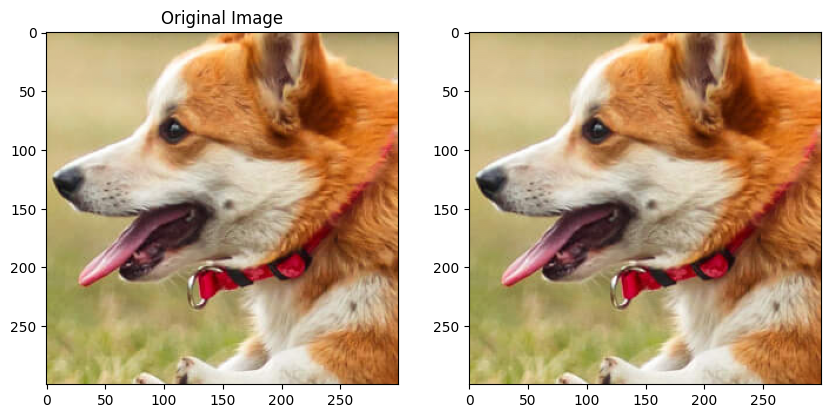

In [10]:
image_flat = image.ravel()
reconstructed_image_flat = reconstructed_image.ravel()

rmse = np.sqrt(mean_squared_error(image_flat.cpu().numpy(), reconstructed_image_flat))
psnr = peak_signal_noise_ratio(image_flat.cpu().numpy(), reconstructed_image_flat)
print((f"Reconstructed Image\nRMSE: {rmse:.4f}, PSNR: {psnr:.2f} dB"))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(rearrange(image[:3], 'c h w -> h w c').cpu().numpy())
#plt.imshow(image.cpu().numpy())
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(rearrange(reconstructed_image[:3], 'c h w -> h w c'))

Q2


In [12]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Load the audio file
audio_path = 'VEHSirn_Ambulance siren 2 (ID 1464)_BSB.wav'
audio, sample_rate = librosa.load(audio_path, sr=None)  

In [13]:

audio_tensor = torch.tensor(audio, dtype=torch.float32).to(device)
audio_size = audio_tensor.shape
coords = torch.arange(audio_size[0], dtype=torch.float32).to(device)
coords = coords.reshape(-1, 1)

In [14]:


scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(coords.cpu().numpy())
X_scaled = scaler_X.transform(coords.cpu().numpy())
X_scaled = torch.tensor(X_scaled, dtype=torch.float32).to(device)
num_features =1000
sigma = 0.0008
Z = create_rff_features(X_scaled, num_features, sigma)
print("created rrf")

created rrf


In [28]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)  # Linear layer for reconstruction

    def forward(self, x):
        return self.linear(x)

def train_model(model, optimizer, Z, target, criterion, num_epochs=1000, print_interval=100):
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad() 
        output = model(Z)
        loss = criterion(output, target) 
        loss.backward() 
        optimizer.step()

        if epoch % print_interval == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')

def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)


In [16]:

input_size = Z.shape[1]
audio_flat = audio.reshape(-1, 1) 
target_tensor = torch.tensor(audio_flat, dtype=torch.float32).to(device)
model = LinearRegressionModel(input_size, 1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
Z = Z.to(device)
train_model(model, optimizer, Z, target_tensor, criterion)
with torch.no_grad():
    reconstructed_flat = model(Z).cpu().numpy()  # Predict the flattened audio
    reconstructed_audio = reconstructed_flat.reshape(-1)  # Reshape to original audio dimensions


Epoch [0/1000], Loss: 0.1838
Epoch [100/1000], Loss: 0.1834
Epoch [200/1000], Loss: 0.1834
Epoch [300/1000], Loss: 0.1834
Epoch [400/1000], Loss: 0.1834
Epoch [500/1000], Loss: 0.1834
Epoch [600/1000], Loss: 0.1834
Epoch [700/1000], Loss: 0.1834
Epoch [800/1000], Loss: 0.1834
Epoch [900/1000], Loss: 0.1834


Reconstructed Audio Waveform
RMSE: 0.4282, SNR: 0.77 dB


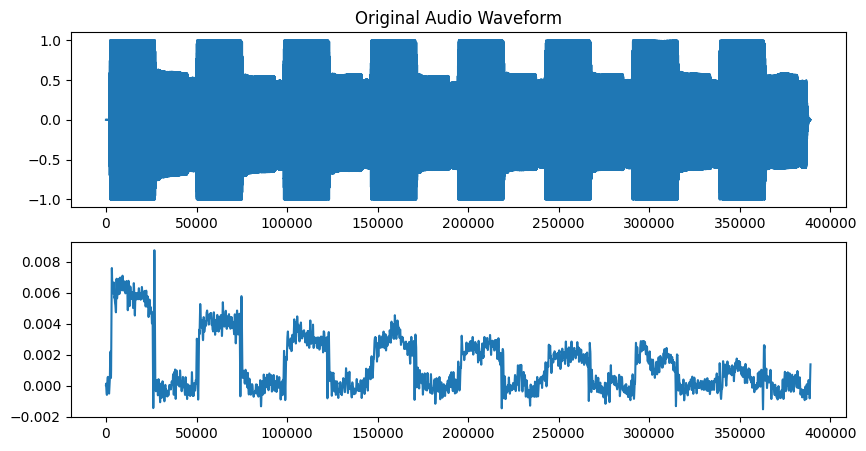

In [27]:
rmse = np.sqrt(mean_squared_error(audio, reconstructed_audio))
snr=signaltonoise(reconstructed_audio, axis=0, ddof=0) 
print(f"Reconstructed Audio Waveform\nRMSE: {rmse:.4f}, SNR: {snr:.2f} dB")
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(audio)
plt.title("Original Audio Waveform")

plt.subplot(2, 1, 2)
plt.plot(reconstructed_audio)
plt.show()

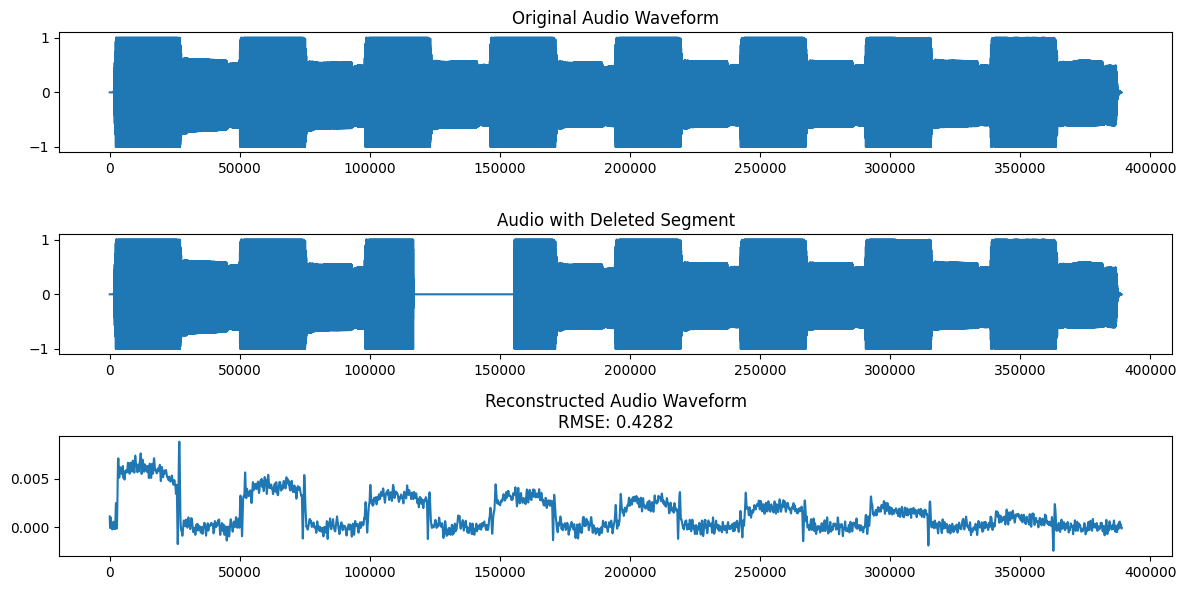

In [13]:
def delete_audio_segment(audio, start, end):
    audio_deleted = audio.copy()
    audio_deleted[start:end] = 0
    return audio_deleted

start_idx = int(0.3 * len(audio))
end_idx = int(0.4 * len(audio))
audio_deleted = delete_audio_segment(audio, start_idx, end_idx)
audio_deleted_flat = audio_deleted.reshape(-1, 1)
target_tensor_deleted = torch.tensor(audio_deleted_flat, dtype=torch.float32).to(device)
with torch.no_grad():
    reconstructed_flat = model(Z).cpu().numpy()  # Predict the flattened audio
    reconstructed_audio = reconstructed_flat.reshape(-1)  # Reshape to original dimensions
reconstructed_audio[start_idx:end_idx] = reconstructed_flat[start_idx:end_idx].reshape(-1)
rmse = np.sqrt(mean_squared_error(audio, reconstructed_audio))
# snr = signaltonoise(audio, reconstructed_audio)
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(audio)
plt.title("Original Audio Waveform")
plt.subplot(3, 1, 2)
plt.plot(audio_deleted)
plt.title("Audio with Deleted Segment")
plt.subplot(3, 1, 3)
plt.plot(reconstructed_audio)
plt.title(f"Reconstructed Audio Waveform\nRMSE: {rmse:.4f}")
plt.tight_layout()
plt.show()


In [14]:
original_segment = audio[start_idx:end_idx]  # Original segment of the audio
reconstructed_segment = reconstructed_audio[start_idx:end_idx]  # Reconstructed segment

rmse_segment = np.sqrt(mean_squared_error(original_segment, reconstructed_segment))
rmse_segment

0.40961492